In [1]:
##This code chunk connects to the "Empatica Streaming Server" and then opens streams to LSL##

import socket
import time
import pylsl

# SELECT DATA TO STREAM
acc = True      # 3-axis acceleration
bvp = True      # Blood Volume Pulse
gsr = True      # Galvanic Skin Response (Electrodermal Activity)
tmp = True      # Temperature

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

def prepare_LSL_streaming():
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
prepare_LSL_streaming()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                #print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp)
                    if stream_type == "E4_Bvp":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBVP.push_sample([data], timestamp=timestamp)
                    if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp)
                    if stream_type == "E4_Temperature":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTemp.push_sample([data], timestamp=timestamp)
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
stream()

Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to ACC
R device_subscribe acc OK

Suscribing to BVP
R device_subscribe bvp OK

Suscribing to GSR
R device_subscribe gsr OK

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
E4_Acc 1624909703.12159 36 2 53

Starting LSL streaming
Streaming...
Disconnecting from device


In [2]:
pip install pyxdf

Note: you may need to restart the kernel to use updated packages.


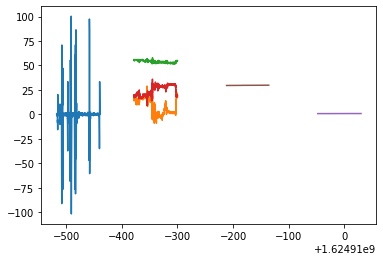

In [2]:
## This code chunk loads the xdf file created from LSL and plots the time series data ##

import pyxdf
import matplotlib.pyplot as plt
import numpy as np

data, header = pyxdf.load_xdf('sub-P001_ses-S001_task-Default_run-001_eeg.xdf')

for stream in data:
    y = stream['time_series']

    if isinstance(y, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker in zip(stream['time_stamps'], y):
            plt.axvline(x=timestamp)
            print(f'Marker "{marker[0]}" @ {timestamp:.2f}s')
    elif isinstance(y, np.ndarray):
        # numeric data, draw as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

plt.show()

# Most code below this point is Anthony's scratch work exploring the xdf file structure

In [13]:
n = 0
for stream in data:
    n += 1
print(n)

4


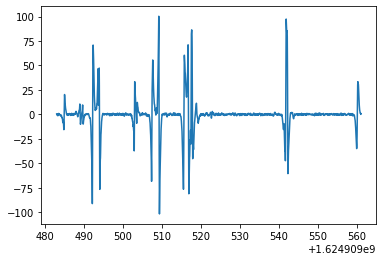

In [33]:
bvp = data[0]
bvp

plt.plot(bvp['time_stamps'], bvp['time_series'])

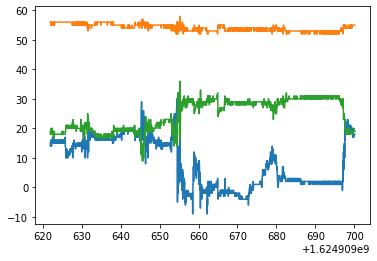

In [37]:
acc = data[1]
acc

plt.plot(acc['time_stamps'], acc['time_series'])

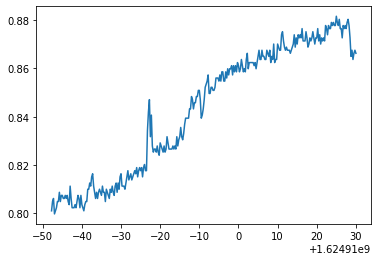

In [41]:
gsr = data[2]
gsr

plt.plot(gsr['time_stamps'], gsr['time_series'])

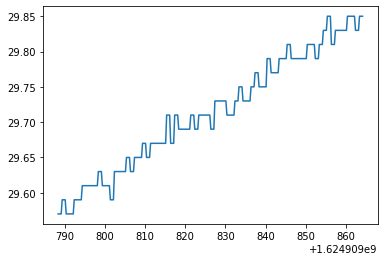

In [44]:
tmp = data[3]
tmp

plt.plot(tmp['time_stamps'], tmp['time_series'])

In [ ]:
data

In [ ]:
for stream in data:
    print(stream)

In [5]:
header

{'info': defaultdict(list,
             {'version': ['1.0'], 'datetime': ['2021-06-28T12:50:31-0700']})}

In [4]:
data

[{'info': defaultdict(list,
              {'name': ['bvp'],
               'type': ['BVP'],
               'channel_count': ['1'],
               'channel_format': ['float32'],
               'source_id': ['BVP-empatica_e4'],
               'nominal_srate': ['64.00000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['61507.42130790000'],
               'uid': ['d51bf6e1-b7e6-48bd-b6e7-47d520390237'],
               'session_id': ['default'],
               'hostname': ['DESKTOP-UFUU8MC'],
               'v4address': [None],
               'v4data_port': ['16573'],
               'v4service_port': ['16573'],
               'v6address': [None],
               'v6data_port': ['16573'],
               'v6service_port': ['16573'],
               'desc': [None],
               'stream_id': 3,
               'effective_srate': 63.99704932945175}),
  'footer': {'info': defaultdict(list,
               {'first_timestamp': ['1624909831.56404'],
         

In [17]:
stream['info']

defaultdict(list,
            {'name': ['tmp'],
             'type': ['Temp'],
             'channel_count': ['1'],
             'channel_format': ['float32'],
             'source_id': ['Temp-empatica_e4'],
             'nominal_srate': ['4.000000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['61507.42618180000'],
             'uid': ['7be49f66-9a55-4412-ac8c-d66d881302f5'],
             'session_id': ['default'],
             'hostname': ['DESKTOP-UFUU8MC'],
             'v4address': [None],
             'v4data_port': ['16575'],
             'v4service_port': ['16575'],
             'v6address': [None],
             'v6data_port': ['16575'],
             'v6service_port': ['16575'],
             'desc': [None],
             'stream_id': 4,
             'effective_srate': 3.999815497627142})

In [18]:
stream['info']['name']

['tmp']

In [19]:
stream['info']['type']

['Temp']

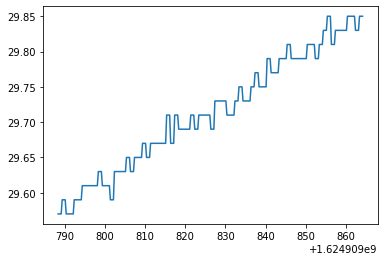

In [21]:
y = stream['time_series']
x = stream['time_stamps']

plt.plot(x, y)

In [23]:
len(stream['time_series'])

304

In [25]:
len(stream['time_stamps'])

304

In [ ]:
data